<a href="https://colab.research.google.com/github/aqafridi/Self-Driving-Car-Project/blob/main/Behavoir%20Cloning/Self_driving_car_Behavior_Cloning_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 29.61 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls track

driving_log.csv  IMG


In [3]:
!pip3 install imgaug -q

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [5]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

total data: 4053
removed: 2590
remaining: 1463
center      center_2018_07_16_17_11_44_413.jpg
left        left_2018_07_16_17_11_44_413.jpg  
right       right_2018_07_16_17_11_44_413.jpg 
steering   -0.05                              
throttle    0.642727                          
reverse     0                                 
speed       1.43401                           
Name: 12, dtype: object


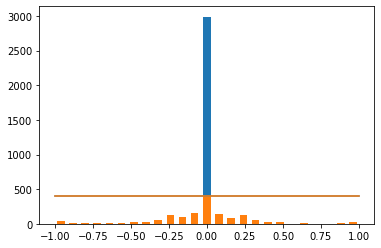

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


print(data.iloc[1])


Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

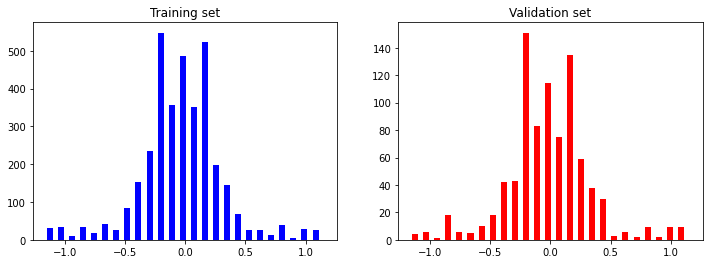

In [7]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')




Text(0.5, 1.0, 'Zoomed Image')

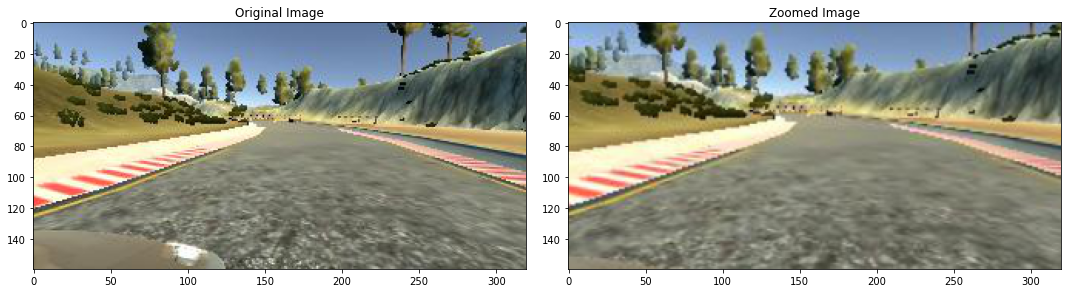

In [8]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')




Text(0.5, 1.0, 'Panned Image')

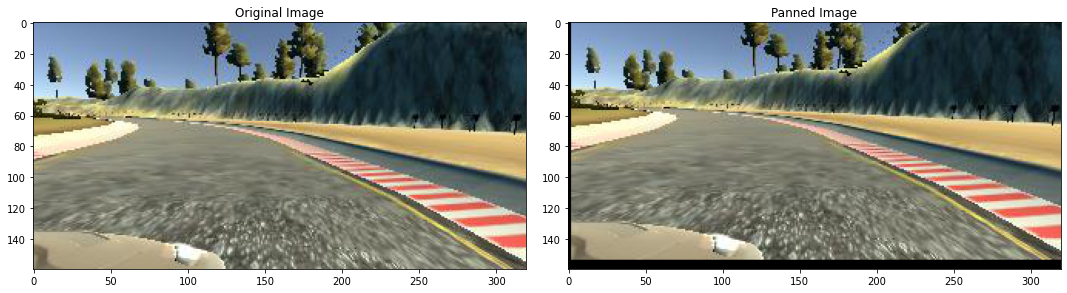

In [9]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')


Text(0.5, 1.0, 'Brightness altered image ')

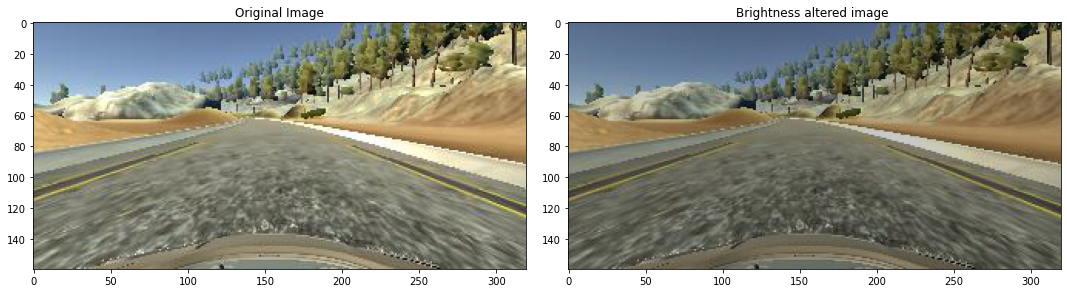

In [10]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')




Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2')

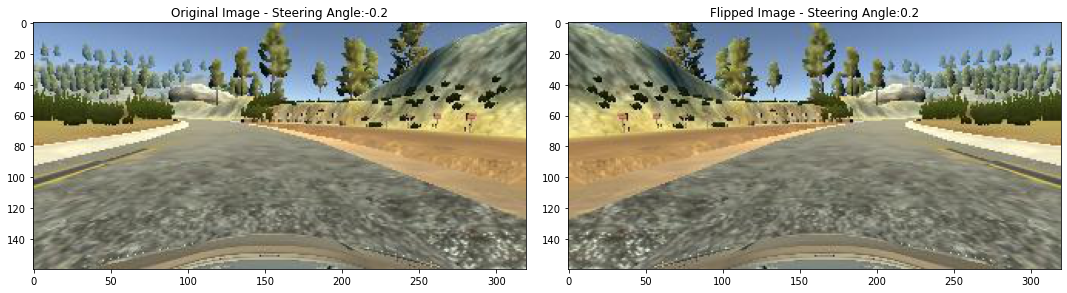

In [11]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))


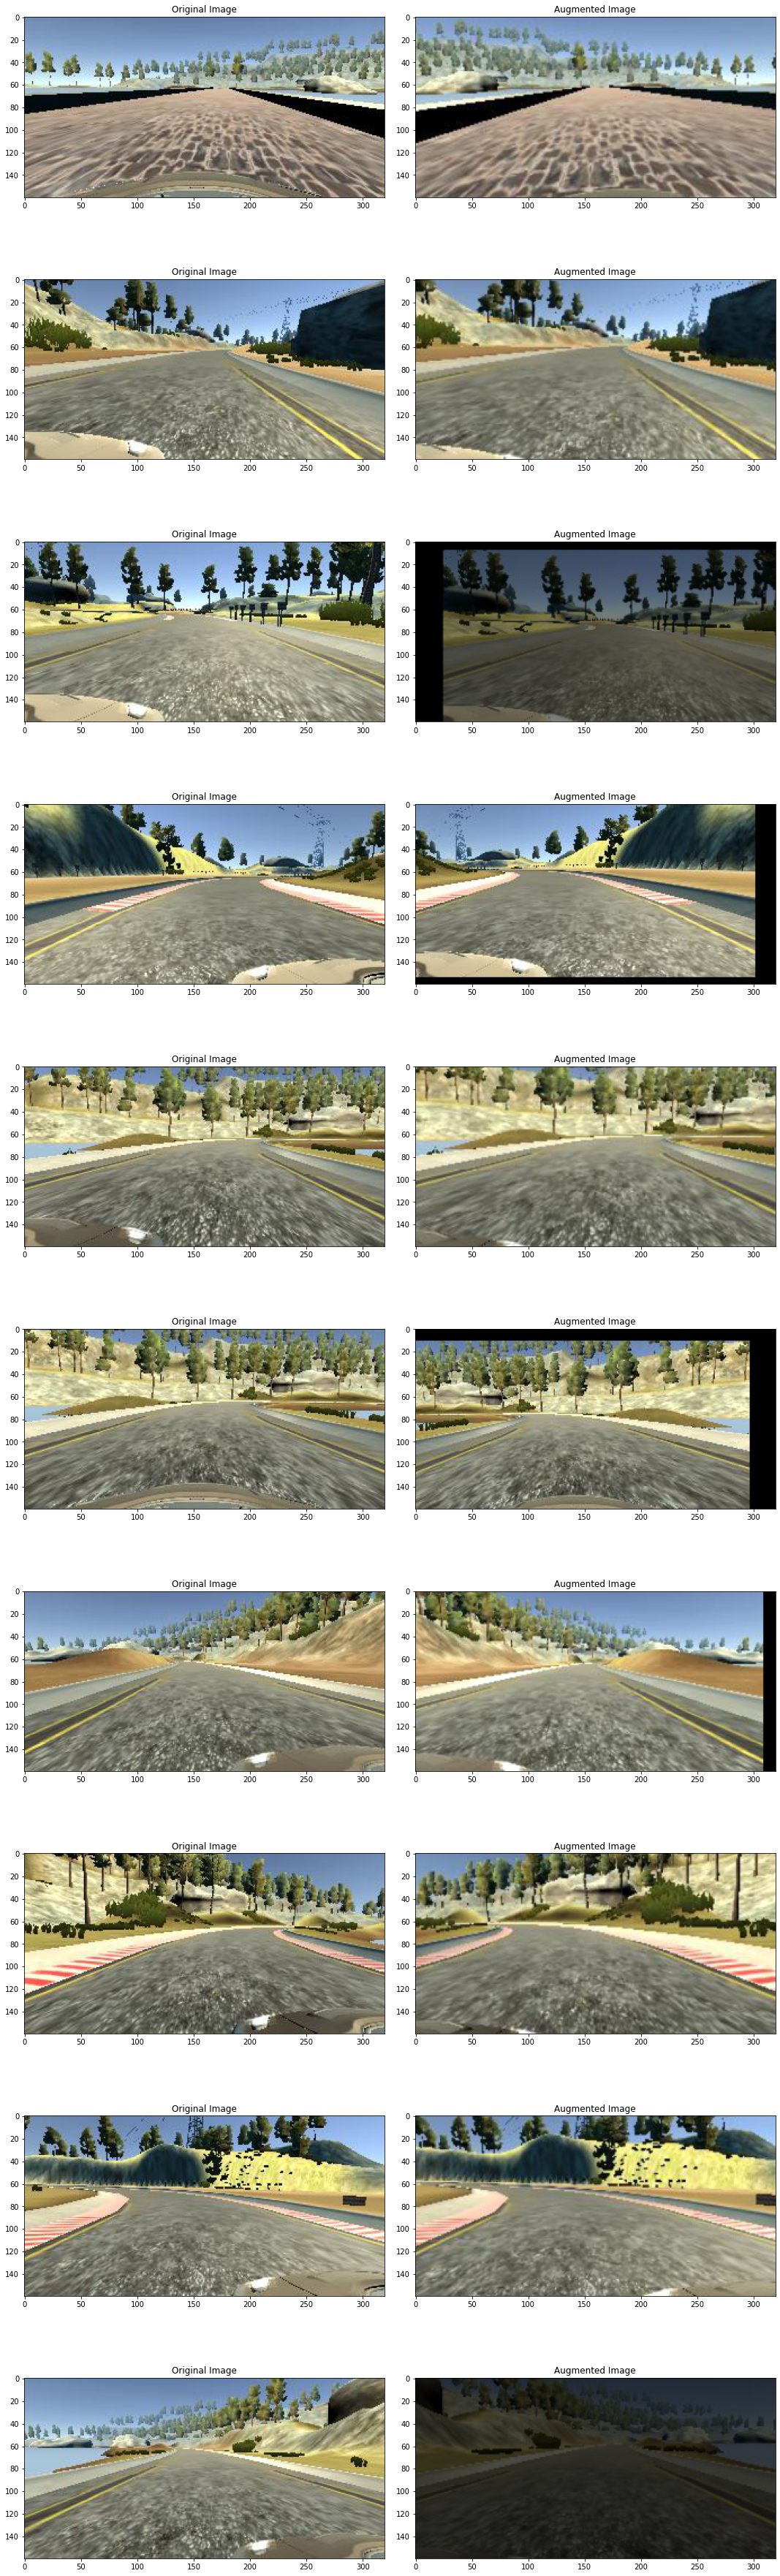

In [12]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")



Text(0.5, 1.0, 'Preprocessed Image')

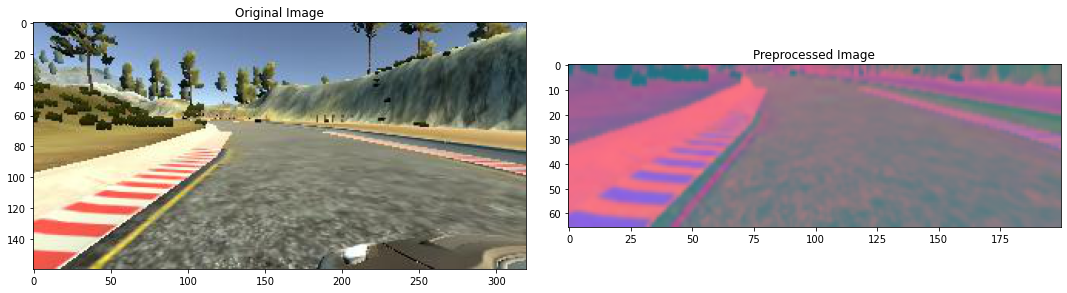

In [13]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


Text(0.5, 1.0, 'Validation Image')

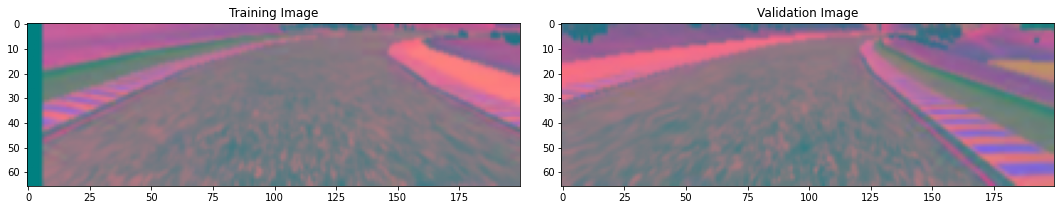

In [14]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [15]:
def nvidia_model():
  model = Sequential([
                      Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'),
                      Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='elu'),
                      Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='elu'),
                      Conv2D(64, kernel_size=(3, 3), activation='elu'),
  
                     Conv2D(64, kernel_size=(3, 3), activation='elu'),
#   model.add(Dropout(0.5))
  
  
                      Flatten(),
  
                      Dense(100, activation = 'elu'),
#   model.add(Dropout(0.5))
  
                      Dense(50, activation = 'elu'),
#   model.add(Dropout(0.5))
  
                      Dense(10, activation = 'elu'),
#   model.add(Dropout(0.5))

                      Dense(1)
  ])
  
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model
model = nvidia_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
300/300 [==============================] - 231s 732ms/step - loss: 0.1209 - val_loss: 0.0592
Epoch 2/10
300/300 [==============================] - 219s 733ms/step - loss: 0.0682 - val_loss: 0.0440
Epoch 3/10
300/300 [==============================] - 216s 722ms/step - loss: 0.0573 - val_loss: 0.0363
Epoch 4/10
300/300 [==============================] - 214s 716ms/step - loss: 0.0516 - val_loss: 0.0378
Epoch 5/10
300/300 [==============================] - 215s 720ms/step - loss: 0.0483 - val_loss: 0.0343
Epoch 6/10
300/300 [==============================] - 223s 744ms/step - loss: 0.0451 - val_loss: 0.0308
Epoch 7/10
300/300 [==============================] - 219s 733ms/step - loss: 0.0431 - val_loss: 0.0293
Epoch 8/10
300/300 [==============================] - 221s 739ms/step - loss: 0.0420 - val_loss: 0.0315
Epoch 9/10
300/300 [==============================] - 215s 720ms/step - loss: 0.0417 - val_loss: 0.0280
Epoch 10/10
300/300 [==============================] - 209s 699m

Text(0.5, 0, 'Epoch')

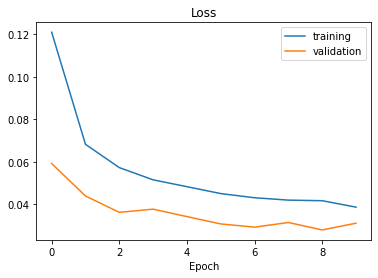

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


In [18]:
model.save('model.h5')


In [19]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import tensorflow as tf

model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwvr4j1jd/assets


INFO:tensorflow:Assets written to: /tmp/tmpwvr4j1jd/assets


1014456

In [27]:
import pathlib
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

1014456